# Step 1. Initialize environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


# Step 2. Import codes for training

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Discrete_Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, fc_units=[256,256,256]):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(Discrete_Actor, self).__init__()
        self.fc1=nn.Linear(state_size,fc_units[0])
        self.fc2=nn.Linear(fc_units[0],fc_units[1])
        self.fc3=nn.Linear(fc_units[1],fc_units[2])
        self.fc4=nn.Linear(fc_units[2],action_size)
        self.output = nn.LogSoftmax(dim=1)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x=F.relu(self.fc1(state))
        x=F.relu(self.fc2(x))
        x=F.relu(self.fc3(x))
        x=self.output(self.fc4(x))
        return(x)
    
class Critic(nn.Module):
    '''This critic does not consider action'''
    def __init__(self, state_size, hidden=[256,256,256]):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden[0])
        self.fc2 = nn.Linear(hidden[0], hidden[1])
        self.fc3 = nn.Linear(hidden[1], hidden[2])
        self.fc4 = nn.Linear(hidden[2], 1)
        self.bn1 = nn.BatchNorm1d(hidden[0])
        self.bn2 = nn.BatchNorm1d(hidden[1])
        self.bn3 = nn.BatchNorm1d(hidden[2])
        
    def forward(self, state):
        x = self.bn1(F.relu(self.fc1(state)))
        x = self.bn2(F.relu(self.fc2(x)))
        x = self.bn3(F.relu(self.fc3(x)))
        x = self.fc4(x)
        return x

In [5]:
import numpy as np
import random
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, TensorDataset, DataLoader

Batch_Size = 128
GAMMA = 0.99            # discount factor for reward
TAU = 0.95              # discount factor for advantage
Beta = 0                # Coefficient for KL divergence
LR1 = 5e-4              # learning rate 
LR2 = 5e-4              # learning rate 
Eps = 0.2               # torelated error of ratio

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, lr1=LR1, lr2=LR2, gamma=GAMMA, tau=TAU, beta=Beta, eps=Eps, method='MC', learning_time=4):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            lr1/lr2 (float): learning rate for actor/critic
            tau (float): decay rate for advantage function
            gamma (float): decay rate for future rewards
        """
        self.state_size = state_size
        self.action_size = action_size
        self.lr1 = lr1
        self.lr2 = lr2
        self.gamma = gamma
        self.tau = tau
        self.beta = beta
        self.batch_size = Batch_Size
        self.eps = eps
        
        self.actor = Discrete_Actor(state_size, action_size).to(device)
        self.critic = Critic(state_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.lr1)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.lr2)
        self.critic.eval()
        if method in ['MC', 'TD']:
            self.method = method
        else:
            print('Only support MC or TD method. Input not supported. Use MC by default')
            self.method = 'MC'
        
        self.learn_time = learning_time # How many updates for each episode

    def act(self, state):
        """
        Returns actions' probabilities for given state as per current policy.
        Also saves the history for later update.
        
        Inputs:
        ==========================
        state(float): the current state, which is a tensor
        """
        log_probs = self.actor(state)
        return log_probs

    def learn(self, states, actions, log_probs, advantages, returns):
        """Update value parameters using the memory of current episode"""
        
        mydata = TensorDataset(states.detach(), actions.detach(), log_probs.detach(), advantages.detach(), returns.detach())
        Loader = DataLoader(mydata, batch_size = self.batch_size, shuffle = True)
        self.critic.train()
        
        for _ in range(self.learn_time):
            for sampled_states, sampled_actions, sampled_log_probs, sampled_advantages, sampled_returns in iter(Loader):
                sampled_actions = sampled_actions.long()
                new_log_probs = self.act(sampled_states)
                ratio = (new_log_probs - sampled_log_probs).exp().gather(1, sampled_actions)
                KL = -sampled_log_probs.exp()*(new_log_probs - sampled_log_probs)
                KL = torch.sum(KL, dim=1, keepdim=True)
                
                estimated_values = self.critic(sampled_states)
                
                Actor_Loss = -torch.min(input=ratio*sampled_advantages, other=torch.clamp(ratio, 1-self.eps, 1+self.eps)*sampled_advantages).mean()
                Actor_Loss += self.beta*KL.mean()
                self.actor_optimizer.zero_grad()
                Actor_Loss.backward()
                torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 5)
                self.actor_optimizer.step()
                
                Critic_Loss = 0.5*(estimated_values - sampled_returns).pow(2).mean()
                self.critic_optimizer.zero_grad()
                Critic_Loss.backward()
                torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 5)
                self.critic_optimizer.step()       
                
        self.critic.eval()

In [6]:
from collections import deque

def PPO_Discrete(n_episodes, max_t, agent, UPDATE):
    """
    Monitor the training process
    Params
    ======
        env, brain_name and agent are assumed to be defined elsewhere
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        UPDATE (int): number of episodes before each update
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    means = []
    state_history = []
    action_history = []
    reward_history = []
    log_prob_history = []
    done_history = []
    for i_episode in range(1, n_episodes+1):
            
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            log_probs = agent.act(torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device))
            log_probs = log_probs.squeeze()
            probs = log_probs.detach().exp().numpy()
            action = np.random.choice(a=agent.action_size, size=1, replace=False, p=probs)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            
            state_history.append(torch.tensor(state, dtype=torch.float32).view(1,-1).to(device))
            action_history.append(torch.tensor(action, dtype=torch.int8).to(device))
            reward_history.append(torch.tensor(reward, dtype=torch.float32).to(device))
            log_prob_history.append(log_probs)
            done_history.append(torch.tensor(done, dtype=torch.float32).to(device))
            
            state = next_state
            score += reward
            if done:
                break
                
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        print('\rEpisode {}\tEpisodic Score: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, score, np.mean(scores_window),), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tEpisodic Score: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, score, np.mean(scores_window)))
        means.append(np.mean(scores_window))  
        
        if i_episode % UPDATE == 0:
            state_history.append(torch.tensor(state, dtype=torch.float32).view(1,-1).to(device))
            Advantages = [] #Save advantages to update actor
            advantages = 0
            Returns = [] #Save MC returns to update critic
            returns = 0
            for i in reversed(range(len(state_history)-1)):
                state = state_history[i]
                next_state = state_history[i+1]
                if agent.method == 'MC':
                    returns = (1-done_history[i])*agent.gamma*returns + reward_history[i]
                else:
                    returns = (1-done_history[i])*agent.gamma*agent.critic(next_state) + reward_history[i]
                Returns.append(returns.detach())
                delta = reward_history[i]+(1-done_history[i])*agent.gamma*agent.critic(next_state)-agent.critic(state)
                advantages = (1-done_history[i])*agent.gamma*agent.tau*advantages + delta
                Advantages.append(advantages.detach())
        
            Advantages.reverse()
            Advantages = torch.stack(Advantages).detach().to(device)
            Advantages = Advantages.view(-1,1)
            Advantages = Advantages.view(UPDATE, -1)
            Advantages = (Advantages - Advantages.mean(dim=0))/Advantages.std(dim=0)
            Advantages = Advantages.view(-1,1)
            Returns.reverse()
            Returns = torch.stack(Returns).detach().to(device)
            Returns = Returns.view(-1,1)
            states = torch.cat(state_history[:-1], 0)
            actions = torch.stack(action_history)
            log_probs = torch.stack(log_prob_history)
            
            agent.learn(states, actions, log_probs, Advantages, Returns)
            
            state_history = []
            action_history = []
            reward_history = []
            log_prob_history = []
            done_history = []
        
    torch.save(agent.actor.state_dict(), 'PPO_{}_checkpoint.pth'.format(agent.method))
    return np.array(scores), np.array(means)

In [7]:
import matplotlib.pyplot as plt

def plot_result(scores, means, suptitle):
    fig = plt.figure(figsize=(20,10))
    fig.suptitle(suptitle)
    
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    average = np.mean(means, axis=0)
    error_bar = np.std(means, axis=0)/np.sqrt(15)
    upper = np.amax(means, axis=0)
    lower = np.amin(means, axis=0)
    ax1.plot(range(1000), average, label='Trajectory of moving average', color='yellow')
    ax1.plot(range(1000), upper, label='Upper bound', color='black')
    ax1.plot(range(1000), lower, label='Lower bound', color='black')
    ax1.fill_between(range(1000), average+1.96*error_bar, average-1.96*error_bar, alpha=0.5)
    ax1.plot(range(1000), 13*np.ones(1000), label='Benchmark',color='gray')
    ax1.set_ylabel('Average')
    ax1.set_xlabel('Episode #')
    ax1.legend(loc=1)
    ax1.set_ylim([0, 20])
    ax1.set_title('Trajectory for moving average')
    
    average = np.mean(scores, axis=0)
    error_bar = np.std(scores, axis=0)/np.sqrt(15)
    upper = np.amax(scores, axis=0)
    lower = np.amin(scores, axis=0)
    ax2.plot(range(1000), average, label='Trajectory of episodic scores', color='yellow')
    ax2.fill_between(range(1000), average+1.96*error_bar, average-1.96*error_bar, alpha=0.5)
    ax2.plot(range(1000), upper, label='Upper bound', color='black')
    ax2.plot(range(1000), lower, label='Lower bound', color='black')
    ax2.plot(range(1000), 13*np.ones(1000), label='Benchmark',color='gray')
    ax2.set_ylabel('Score')
    ax2.set_xlabel('Episode #')
    ax2.legend(loc=1)
    ax2.set_ylim([0, 30])
    ax2.set_title('Trajectory for episodic rewards')
    
    plt.show()

# Step 3. Train the agent and see the result

In [8]:
means = np.zeros((15, 1000))
scores = np.zeros((15, 1000))
for i in range(15):
    print('Test No.{}:'.format(i+1))
    agent = Agent(state_size=state_size, action_size=action_size, method='MC', learning_time=3, lr1=0.001, lr2=0.001)
    scores[i,:], means[i,:] = PPO_Discrete(n_episodes=1000, max_t=1000, agent=agent, UPDATE=10)

Test No.1:
Episode 100	Episodic Score: 3.00	Average Score: 0.872
Episode 200	Episodic Score: 3.00	Average Score: 4.383
Episode 300	Episodic Score: 6.00	Average Score: 5.449
Episode 400	Episodic Score: 9.00	Average Score: 6.746
Episode 500	Episodic Score: 4.00	Average Score: 8.786
Episode 600	Episodic Score: 10.00	Average Score: 8.89
Episode 700	Episodic Score: 16.00	Average Score: 9.66
Episode 800	Episodic Score: 14.00	Average Score: 11.04
Episode 900	Episodic Score: 9.00	Average Score: 10.027
Episode 1000	Episodic Score: 7.00	Average Score: 8.424
Test No.2:
Episode 100	Episodic Score: 1.00	Average Score: 0.323
Episode 200	Episodic Score: 4.00	Average Score: 4.307
Episode 300	Episodic Score: 7.00	Average Score: 8.267
Episode 400	Episodic Score: 7.00	Average Score: 11.500
Episode 500	Episodic Score: 13.00	Average Score: 10.64
Episode 600	Episodic Score: 5.00	Average Score: 11.231
Episode 700	Episodic Score: 14.00	Average Score: 12.59
Episode 800	Episodic Score: 11.00	Average Score: 11.6

Episode 800	Episodic Score: 8.00	Average Score: 12.942
Episode 900	Episodic Score: 1.00	Average Score: 11.596
Episode 1000	Episodic Score: 15.00	Average Score: 12.04


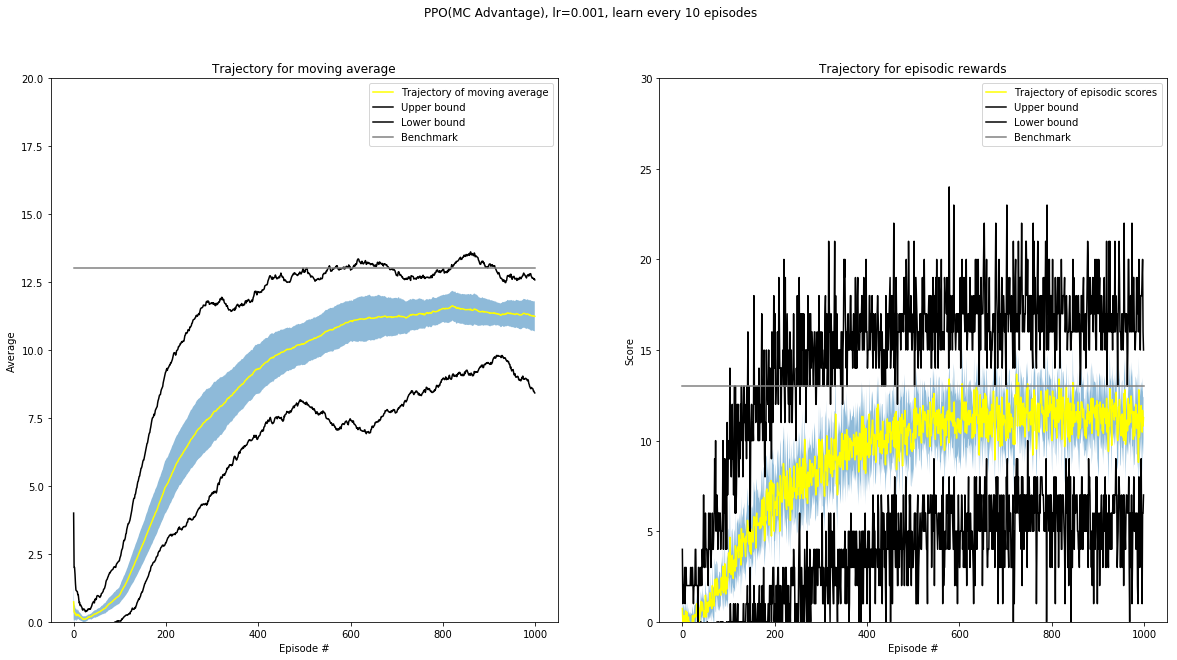

In [9]:
plot_result(scores, means, 'PPO(MC Advantage), lr=0.001, learn every 10 episodes')

In [8]:
means = np.zeros((15, 1000))
scores = np.zeros((15, 1000))
for i in range(15):
    print('Test No.{}:'.format(i+1))
    agent = Agent(state_size=state_size, action_size=action_size, method='TD', learning_time=3, lr1=0.001, lr2=0.001)
    scores[i,:], means[i,:] = PPO_Discrete(n_episodes=1000, max_t=1000, agent=agent, UPDATE=10)

Test No.1:
Episode 100	Episodic Score: 0.00	Average Score: 0.710
Episode 200	Episodic Score: 6.00	Average Score: 4.145
Episode 300	Episodic Score: 9.00	Average Score: 6.321
Episode 400	Episodic Score: 1.00	Average Score: 8.031
Episode 500	Episodic Score: 3.00	Average Score: 7.352
Episode 600	Episodic Score: 10.00	Average Score: 7.71
Episode 700	Episodic Score: 5.00	Average Score: 8.603
Episode 800	Episodic Score: 3.00	Average Score: 8.824
Episode 900	Episodic Score: 12.00	Average Score: 9.41
Episode 1000	Episodic Score: 8.00	Average Score: 8.99
Test No.2:
Episode 100	Episodic Score: 4.00	Average Score: 1.052
Episode 200	Episodic Score: 10.00	Average Score: 4.88
Episode 300	Episodic Score: 15.00	Average Score: 9.90
Episode 400	Episodic Score: 9.00	Average Score: 12.295
Episode 500	Episodic Score: 13.00	Average Score: 12.93
Episode 600	Episodic Score: 16.00	Average Score: 12.94
Episode 700	Episodic Score: 11.00	Average Score: 12.86
Episode 800	Episodic Score: 12.00	Average Score: 12.29
E

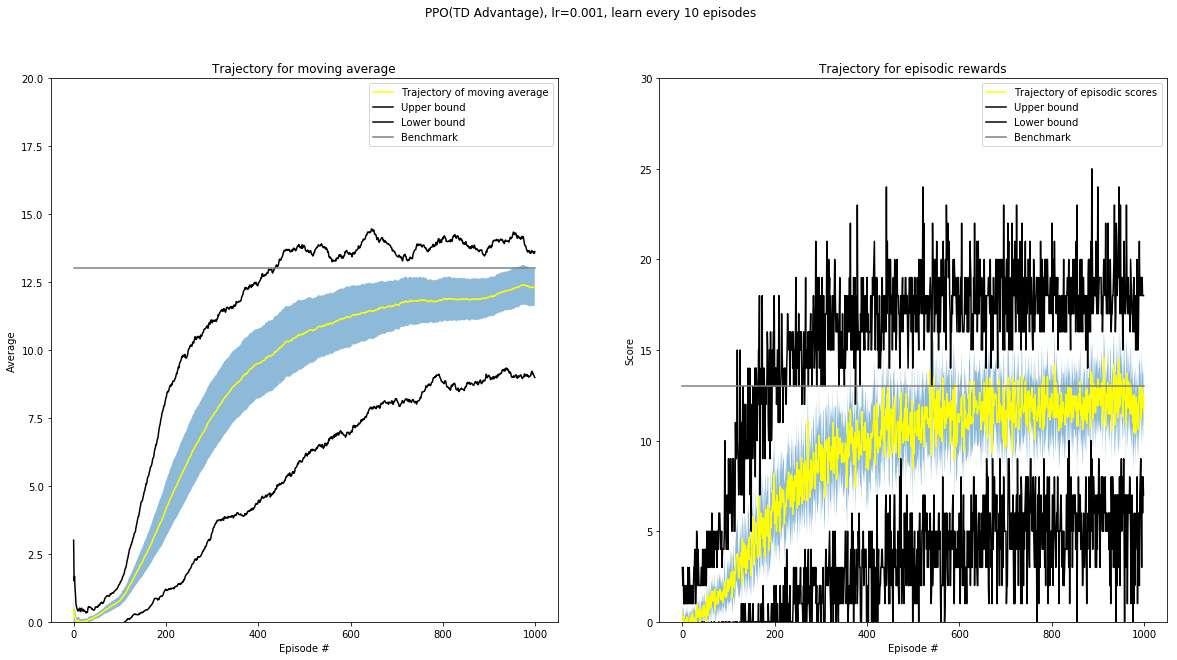

In [9]:
plot_result(scores, means, 'PPO(TD Advantage), lr=0.001, learn every 10 episodes')

In [10]:
means = np.zeros((15, 1000))
scores = np.zeros((15, 1000))
for i in range(15):
    print('Test No.{}:'.format(i+1))
    agent = Agent(state_size=state_size, action_size=action_size, method='MC', learning_time=3, lr1=0.0005, lr2=0.0005)
    scores[i,:], means[i,:] = PPO_Discrete(n_episodes=1000, max_t=1000, agent=agent, UPDATE=10)

Test No.1:
Episode 100	Episodic Score: 2.00	Average Score: 0.90
Episode 200	Episodic Score: 1.00	Average Score: 4.122
Episode 300	Episodic Score: 7.00	Average Score: 8.226
Episode 400	Episodic Score: 7.00	Average Score: 10.733
Episode 500	Episodic Score: 12.00	Average Score: 11.53
Episode 600	Episodic Score: 12.00	Average Score: 12.56
Episode 700	Episodic Score: 17.00	Average Score: 12.58
Episode 800	Episodic Score: 11.00	Average Score: 12.85
Episode 900	Episodic Score: 18.00	Average Score: 13.27
Episode 1000	Episodic Score: 13.00	Average Score: 13.78
Test No.2:
Episode 100	Episodic Score: 5.00	Average Score: 0.293
Episode 200	Episodic Score: 5.00	Average Score: 2.949
Episode 300	Episodic Score: 7.00	Average Score: 8.759
Episode 400	Episodic Score: 5.00	Average Score: 10.480
Episode 500	Episodic Score: 16.00	Average Score: 12.08
Episode 600	Episodic Score: 14.00	Average Score: 12.87
Episode 700	Episodic Score: 15.00	Average Score: 13.62
Episode 800	Episodic Score: 12.00	Average Score: 

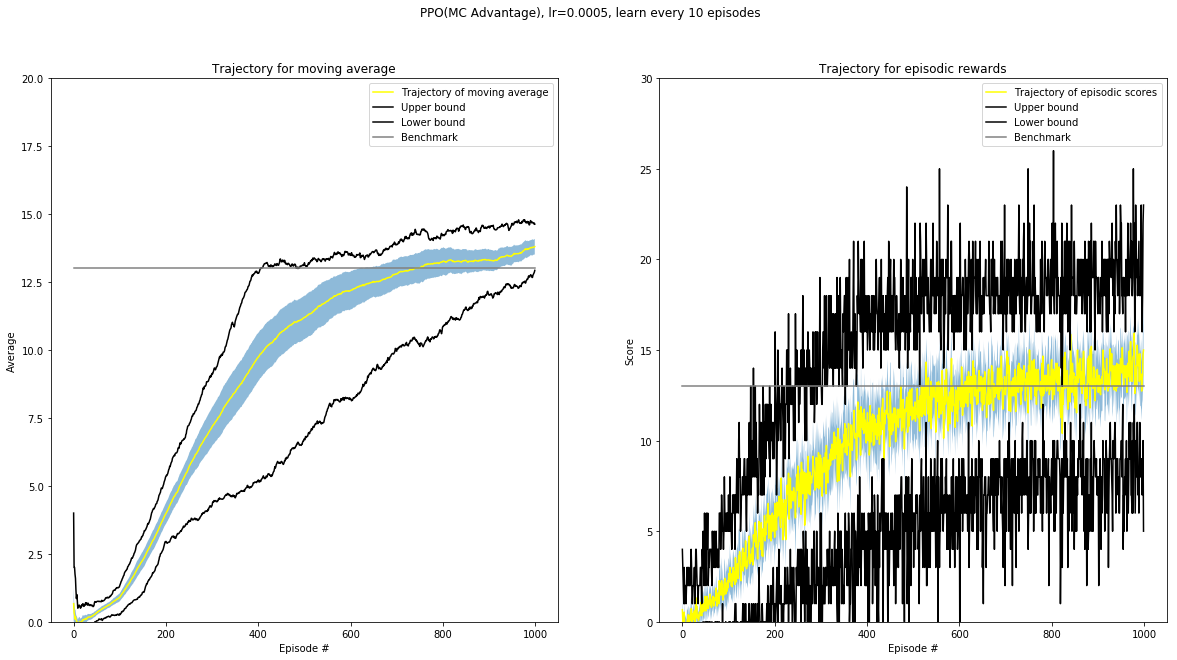

In [11]:
plot_result(scores, means, 'PPO(MC Advantage), lr=0.0005, learn every 10 episodes')

In [13]:
means = np.zeros((15, 1000))
scores = np.zeros((15, 1000))
for i in range(15):
    print('Test No.{}:'.format(i+1))
    agent = Agent(state_size=state_size, action_size=action_size, method='TD', learning_time=3, lr1=0.0005, lr2=0.0005)
    scores[i,:], means[i,:] = PPO_Discrete(n_episodes=1000, max_t=1000, agent=agent, UPDATE=10)

Test No.1:
Episode 100	Episodic Score: 3.00	Average Score: 1.16
Episode 200	Episodic Score: 3.00	Average Score: 4.599
Episode 300	Episodic Score: 11.00	Average Score: 7.59
Episode 400	Episodic Score: 13.00	Average Score: 9.72
Episode 500	Episodic Score: 8.00	Average Score: 9.9190
Episode 600	Episodic Score: 13.00	Average Score: 10.77
Episode 700	Episodic Score: 10.00	Average Score: 10.78
Episode 800	Episodic Score: 6.00	Average Score: 11.142
Episode 900	Episodic Score: 7.00	Average Score: 10.509
Episode 1000	Episodic Score: 10.00	Average Score: 10.66
Test No.2:
Episode 100	Episodic Score: 4.00	Average Score: 1.10
Episode 200	Episodic Score: 10.00	Average Score: 6.60
Episode 300	Episodic Score: 10.00	Average Score: 9.97
Episode 400	Episodic Score: 17.00	Average Score: 12.18
Episode 500	Episodic Score: 15.00	Average Score: 13.12
Episode 600	Episodic Score: 16.00	Average Score: 12.59
Episode 700	Episodic Score: 14.00	Average Score: 13.73
Episode 800	Episodic Score: 14.00	Average Score: 13

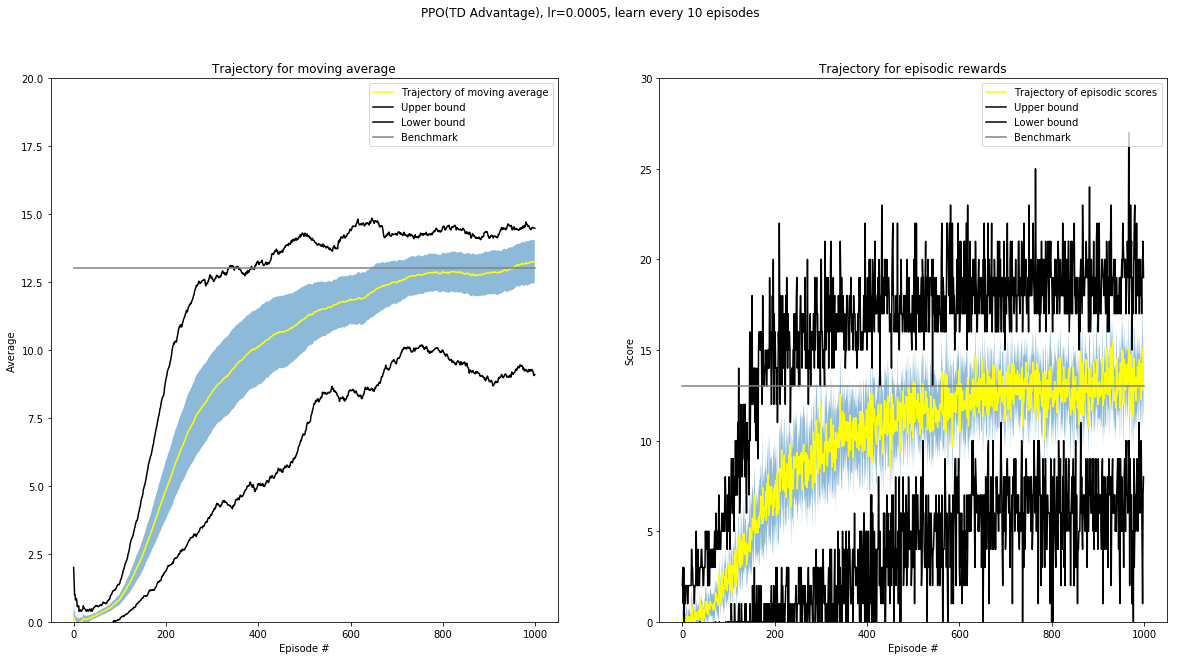

In [14]:
plot_result(scores, means, 'PPO(TD Advantage), lr=0.0005, learn every 10 episodes')

In [15]:
means = np.zeros((15, 1000))
scores = np.zeros((15, 1000))
for i in range(15):
    print('Test No.{}:'.format(i+1))
    agent = Agent(state_size=state_size, action_size=action_size, method='MC', learning_time=3, lr1=0.0001, lr2=0.0001)
    scores[i,:], means[i,:] = PPO_Discrete(n_episodes=1000, max_t=1000, agent=agent, UPDATE=10)

Test No.1:
Episode 100	Episodic Score: 2.00	Average Score: 0.122
Episode 200	Episodic Score: 3.00	Average Score: 1.060
Episode 300	Episodic Score: 6.00	Average Score: 5.085
Episode 400	Episodic Score: 8.00	Average Score: 7.875
Episode 500	Episodic Score: 12.00	Average Score: 9.55
Episode 600	Episodic Score: 11.00	Average Score: 11.61
Episode 700	Episodic Score: 10.00	Average Score: 12.42
Episode 800	Episodic Score: 10.00	Average Score: 12.83
Episode 900	Episodic Score: 14.00	Average Score: 13.56
Episode 1000	Episodic Score: 14.00	Average Score: 14.36
Test No.2:
Episode 100	Episodic Score: 0.00	Average Score: 0.326
Episode 200	Episodic Score: 10.00	Average Score: 3.63
Episode 300	Episodic Score: 15.00	Average Score: 9.53
Episode 400	Episodic Score: 10.00	Average Score: 12.49
Episode 500	Episodic Score: 12.00	Average Score: 13.14
Episode 600	Episodic Score: 12.00	Average Score: 14.25
Episode 700	Episodic Score: 10.00	Average Score: 14.50
Episode 800	Episodic Score: 13.00	Average Score: 1

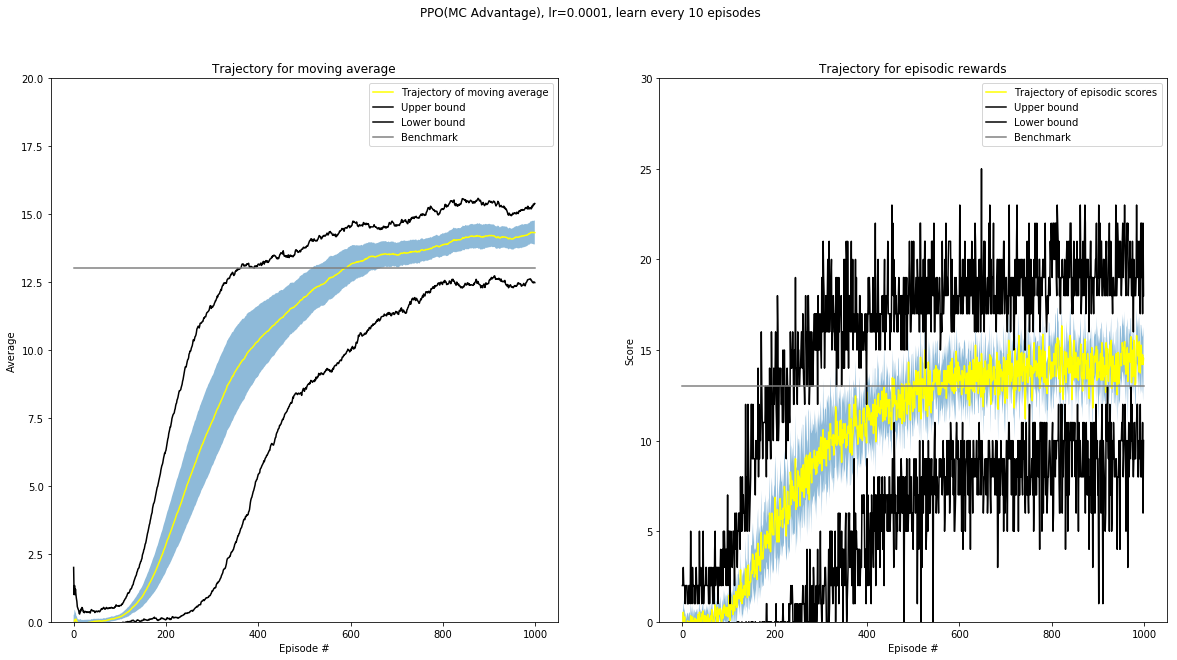

In [17]:
plot_result(scores, means, 'PPO(MC Advantage), lr=0.0001, learn every 10 episodes')

In [18]:
means = np.zeros((15, 1000))
scores = np.zeros((15, 1000))
for i in range(15):
    print('Test No.{}:'.format(i+1))
    agent = Agent(state_size=state_size, action_size=action_size, method='TD', learning_time=3, lr1=0.0001, lr2=0.0001)
    scores[i,:], means[i,:] = PPO_Discrete(n_episodes=1000, max_t=1000, agent=agent, UPDATE=10)

Test No.1:
Episode 100	Episodic Score: 2.00	Average Score: 0.57
Episode 200	Episodic Score: 9.00	Average Score: 6.269
Episode 300	Episodic Score: 11.00	Average Score: 11.64
Episode 400	Episodic Score: 13.00	Average Score: 12.79
Episode 500	Episodic Score: 16.00	Average Score: 13.14
Episode 600	Episodic Score: 16.00	Average Score: 13.43
Episode 700	Episodic Score: 14.00	Average Score: 13.96
Episode 800	Episodic Score: 15.00	Average Score: 14.01
Episode 900	Episodic Score: 15.00	Average Score: 13.82
Episode 1000	Episodic Score: 11.00	Average Score: 13.51
Test No.2:
Episode 100	Episodic Score: -3.00	Average Score: 0.07
Episode 200	Episodic Score: 0.00	Average Score: 0.727
Episode 300	Episodic Score: 2.00	Average Score: 1.715
Episode 400	Episodic Score: 1.00	Average Score: 3.470
Episode 500	Episodic Score: 2.00	Average Score: 5.546
Episode 600	Episodic Score: 13.00	Average Score: 7.01
Episode 700	Episodic Score: 8.00	Average Score: 9.861
Episode 800	Episodic Score: 11.00	Average Score: 11.

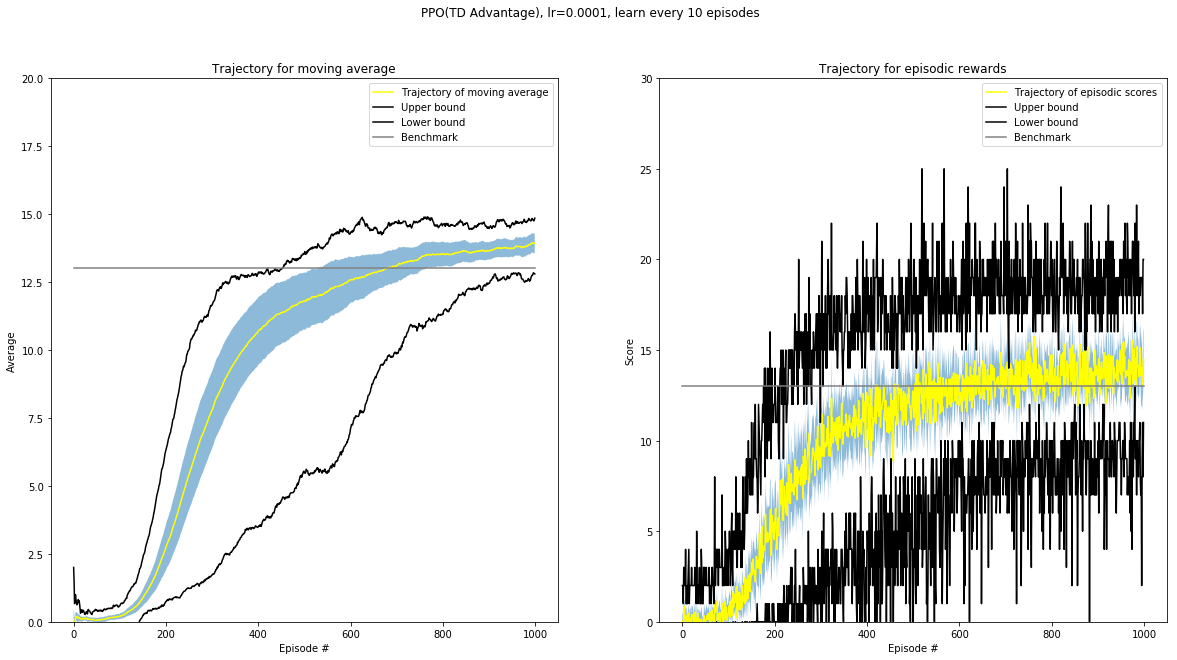

In [19]:
plot_result(scores, means, 'PPO(TD Advantage), lr=0.0001, learn every 10 episodes')

In [8]:
means = np.zeros((15, 1000))
scores = np.zeros((15, 1000))
for i in range(15):
    print('Test No.{}:'.format(i+1))
    agent = Agent(state_size=state_size, action_size=action_size, method='TD', learning_time=3, lr1=0.0001, lr2=0.0001)
    scores[i,:], means[i,:] = PPO_Discrete(n_episodes=1000, max_t=1000, agent=agent, UPDATE=5)

Test No.1:
Episode 100	Episodic Score: 1.00	Average Score: 0.114
Episode 200	Episodic Score: 6.00	Average Score: 0.620
Episode 300	Episodic Score: 10.00	Average Score: 5.48
Episode 400	Episodic Score: 12.00	Average Score: 11.02
Episode 500	Episodic Score: 14.00	Average Score: 12.81
Episode 600	Episodic Score: 9.00	Average Score: 13.150
Episode 700	Episodic Score: 15.00	Average Score: 13.06
Episode 800	Episodic Score: 17.00	Average Score: 12.99
Episode 900	Episodic Score: 14.00	Average Score: 13.58
Episode 1000	Episodic Score: 13.00	Average Score: 14.30
Test No.2:
Episode 100	Episodic Score: 1.00	Average Score: -0.10
Episode 200	Episodic Score: 4.00	Average Score: 1.3552
Episode 300	Episodic Score: 9.00	Average Score: 6.829
Episode 400	Episodic Score: 14.00	Average Score: 10.65
Episode 500	Episodic Score: 9.00	Average Score: 12.605
Episode 600	Episodic Score: 13.00	Average Score: 13.18
Episode 700	Episodic Score: 11.00	Average Score: 12.85
Episode 800	Episodic Score: 14.00	Average Score

Episode 700	Episodic Score: 17.00	Average Score: 14.21
Episode 800	Episodic Score: 16.00	Average Score: 14.29
Episode 900	Episodic Score: 15.00	Average Score: 14.86
Episode 1000	Episodic Score: 14.00	Average Score: 15.37


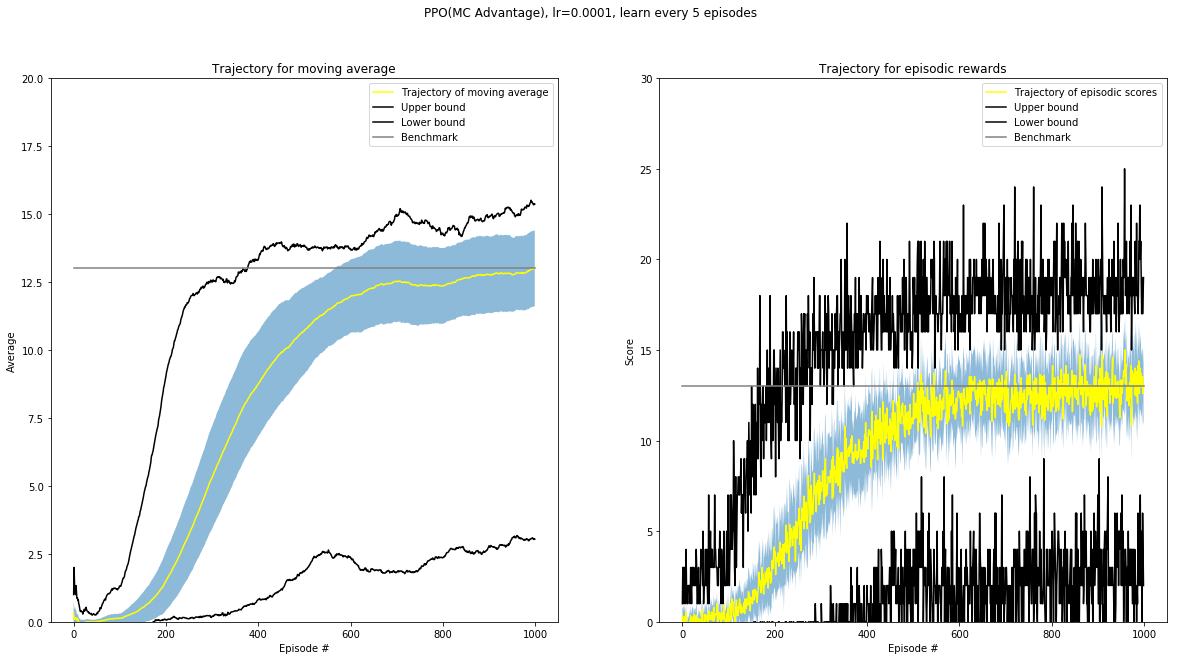

In [9]:
plot_result(scores, means, 'PPO(MC Advantage), lr=0.0001, learn every 5 episodes')

In [10]:
means = np.zeros((15, 1000))
scores = np.zeros((15, 1000))
for i in range(15):
    print('Test No.{}:'.format(i+1))
    agent = Agent(state_size=state_size, action_size=action_size, method='TD', learning_time=3, lr1=0.0001, lr2=0.0001)
    scores[i,:], means[i,:] = PPO_Discrete(n_episodes=1000, max_t=1000, agent=agent, UPDATE=5)

Test No.1:
Episode 100	Episodic Score: 0.00	Average Score: 0.09
Episode 200	Episodic Score: 3.00	Average Score: 0.5741
Episode 300	Episodic Score: 8.00	Average Score: 5.272
Episode 400	Episodic Score: 8.00	Average Score: 10.499
Episode 500	Episodic Score: 12.00	Average Score: 12.81
Episode 600	Episodic Score: 15.00	Average Score: 13.56
Episode 700	Episodic Score: 19.00	Average Score: 13.90
Episode 800	Episodic Score: 17.00	Average Score: 14.91
Episode 900	Episodic Score: 14.00	Average Score: 14.97
Episode 1000	Episodic Score: 15.00	Average Score: 14.16
Test No.2:
Episode 100	Episodic Score: 4.00	Average Score: 0.52
Episode 200	Episodic Score: 10.00	Average Score: 6.37
Episode 300	Episodic Score: 18.00	Average Score: 11.65
Episode 400	Episodic Score: 13.00	Average Score: 12.42
Episode 500	Episodic Score: 11.00	Average Score: 12.87
Episode 600	Episodic Score: 17.00	Average Score: 12.67
Episode 700	Episodic Score: 15.00	Average Score: 12.94
Episode 800	Episodic Score: 13.00	Average Score:

Episode 700	Episodic Score: 10.00	Average Score: 13.15
Episode 800	Episodic Score: 17.00	Average Score: 13.45
Episode 900	Episodic Score: 14.00	Average Score: 14.32
Episode 1000	Episodic Score: 12.00	Average Score: 13.67


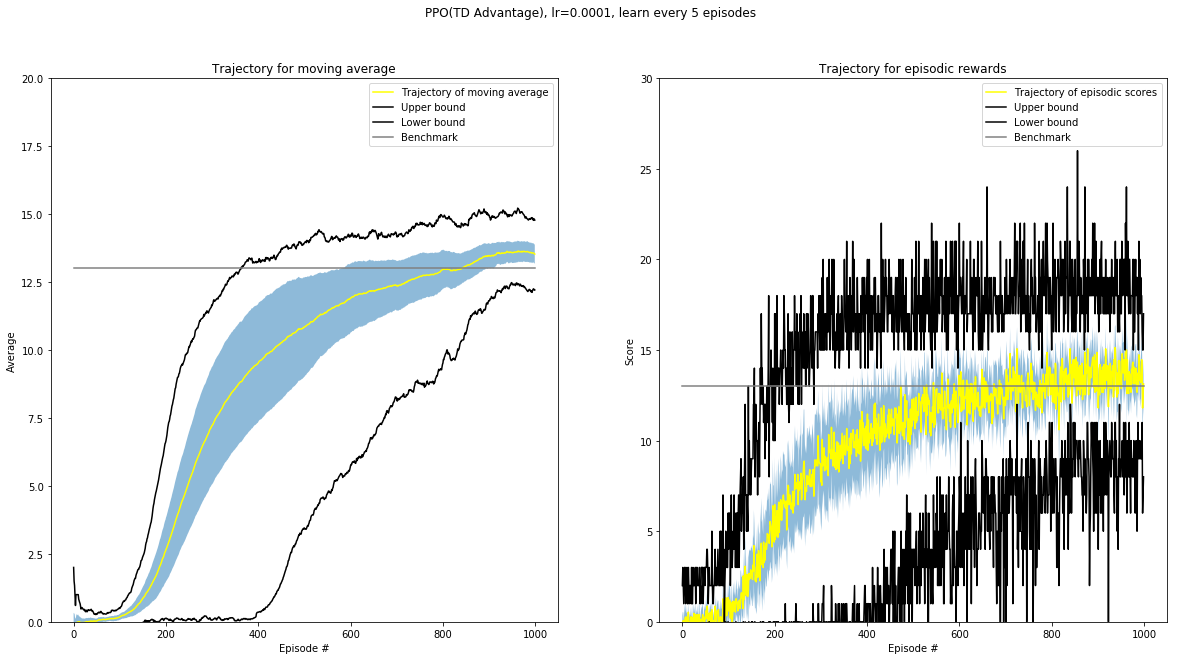

In [11]:
plot_result(scores, means, 'PPO(TD Advantage), lr=0.0001, learn every 5 episodes')

In [12]:
env.close()